# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [70]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

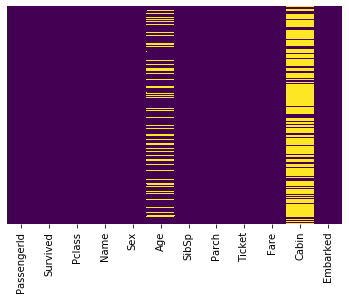

In [7]:
sns.heatmap(train.isnull(),
           yticklabels=False,
           cbar=False,
           cmap='viridis')

In [11]:
# Find the proportion of the missing values of the Age column
round(sum(train['Age'].isnull())/len(train['Age']), 2)

0.2

In [14]:
train.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

## Data Cleaning
**Fill the missing data of the Age column according to the Pclass ticket the passenger bought.**

In [72]:
def impute_age (cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return round(train.groupby('Pclass').mean()['Age'].loc[1],0)
        elif Pclass == 2:
            return round(train.groupby('Pclass').mean()['Age'].loc[2],0)
        else:
            return round(train.groupby('Pclass').mean()['Age'].loc[3],0)
    else:
        return Age

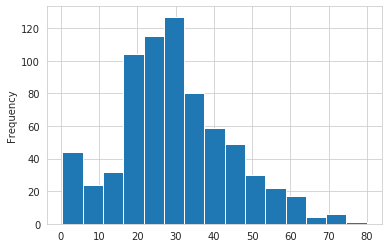

In [73]:
## Plot histogram before fill the missing values
sns.set_style('whitegrid')
train['Age'].plot.hist(bins=15)

In [74]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

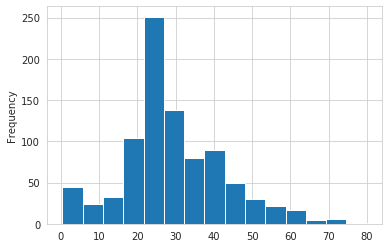

In [75]:
# Plot the histogram without missing values and check the differences
train['Age'].plot.hist(bins=15)

In [76]:
# Drop the Cabin column, because proportion of the missing values is very big. 
train.drop('Cabin', axis=1, inplace=True)

In [77]:
# Finally drop the rows which have missing values
train.dropna(inplace=True)

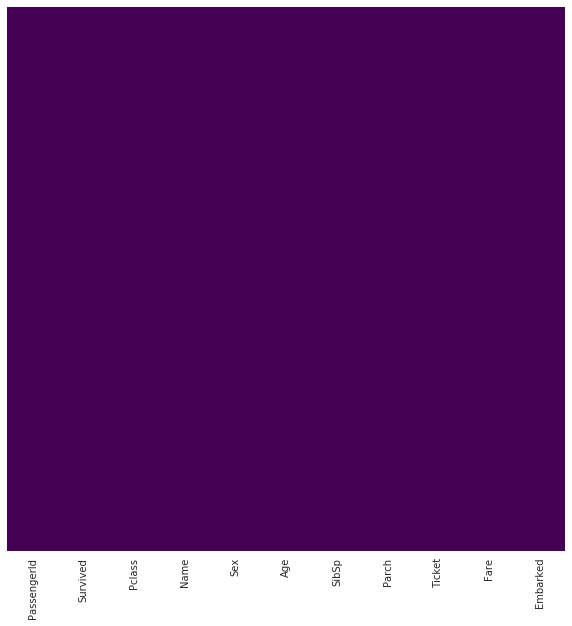

In [78]:
plt.figure(figsize=(10,10))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Explore the data

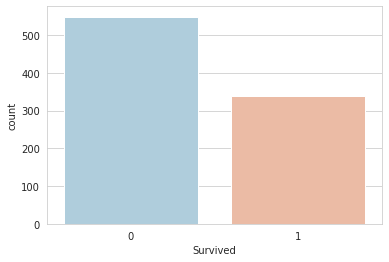

In [23]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

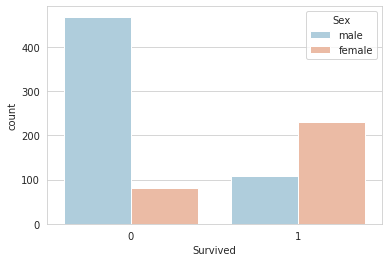

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

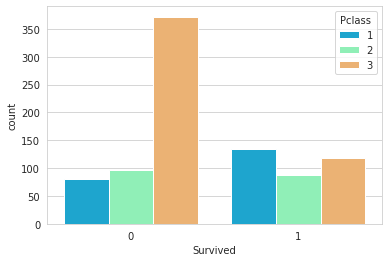

In [25]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

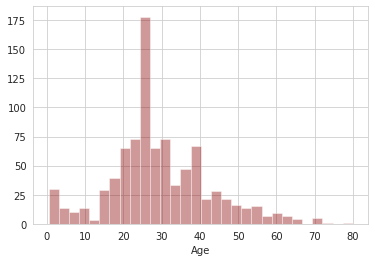

In [29]:
sns.distplot(train['Age'],kde=False,color='darkred',bins=30)

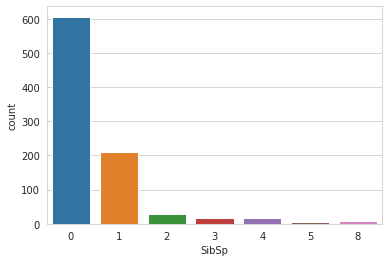

In [30]:
sns.countplot(x='SibSp',data=train)

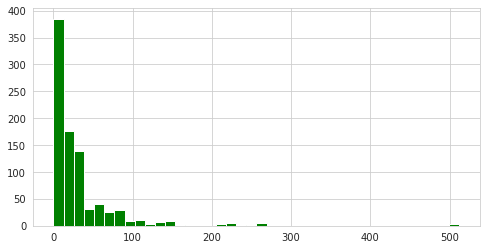

In [31]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Cufflinks for plots
___
 Let's take a quick moment to show an example of cufflinks!

In [32]:
import cufflinks as cf
cf.go_offline()

In [33]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

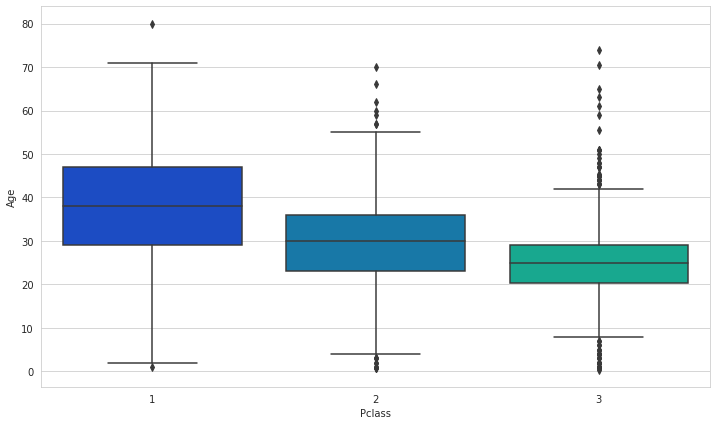

In [34]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 123.3+ KB


In [79]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [80]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [81]:
train.drop('PassengerId', axis=1, inplace=True)

In [82]:
train = pd.concat([train, sex, embark], axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [85]:
from sklearn.linear_model import LogisticRegression

In [92]:
logmodel = LogisticRegression(max_iter=234)

In [93]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=234,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
predictions = logmodel.predict(X_test)

## Evaluation

We can check precision,recall,f1-score using classification report!

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

In [96]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       163
           1       0.85      0.70      0.77       104

    accuracy                           0.84       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.84      0.84      0.83       267



In [98]:
confusion_matrix(y_test,predictions)

array([[150,  13],
       [ 31,  73]])

In [99]:
y_test.value_counts()

0    163
1    104
Name: Survived, dtype: int64

In [100]:
logmodel.score(X_test, y_test)

0.8352059925093633

In [102]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S'], dtype='object')

In [103]:
logmodel.coef_[0]

array([-1.09721958e+00, -4.16066946e-02, -2.48095891e-01, -9.00744467e-02,
        1.63098791e-03, -2.47690900e+00, -1.06877552e-01, -3.33072049e-01])

In [104]:
coefs = pd.DataFrame(logmodel.coef_[0], X_train.columns, columns=['Coefficients'])
coefs

,Coefficients
Pclass,-1.097220
Age,-0.041607
SibSp,-0.248096
Parch,-0.090074
Fare,0.001631
male,-2.476909
Q,-0.106878
S,-0.333072


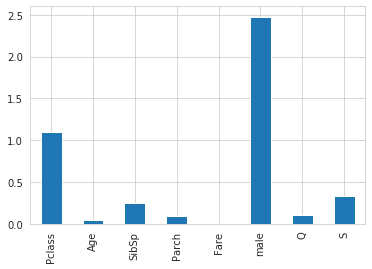

In [105]:
coefs['Coefficients'].apply(lambda x: np.abs(x)).plot.bar()

In [107]:
logmodel.predict_proba(X_test)[0]

array([0.89079736, 0.10920264])